# Travelling Salesperson Problem (TSP) solved by genetic algorithm optimalization

Sources:
- http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
- https://gist.github.com/turbofart/3428880
- https://github.com/maoaiz/tsp-genetic-python/blob/master/tsp-genetic-python.py

In [1]:
"""
Source: https://gist.github.com/turbofart/3428880

This Python code is based on Java code by Lee Jacobson found in an article
entitled "Applying a genetic algorithm to the travelling salesman problem"
that can be found at: http://goo.gl/cJEY1
"""

import math
import random


class City:
    def __init__(self, x=None, y=None):
        self.x = None
        self.y = None

        if x is not None:
            self.x = x
        else:
            self.x = int(random.random() * 1000)
            
        if y is not None:
            self.y = y
        else:
            self.y = int(random.random() * 1000)            

    def getX(self):
        return self.x

    def getY(self):
        return self.y

    def distanceTo(self, city):
        xDistance = abs(self.getX() - city.getX())
        yDistance = abs(self.getY() - city.getY())
        distance = math.sqrt((xDistance * xDistance) + (yDistance * yDistance))
        return distance

    def __repr__(self):
        return str(self.getX()) + ", " + str(self.getY())


class TourManager:
    def __init__(self):    
        self.destinationCities = []

    def addCity(self, city):
        self.destinationCities.append(city)

    def getCity(self, index):
        return self.destinationCities[index]

    def numberOfCities(self):
        return len(self.destinationCities)
    
    def getCities(self):
        return self.destinationCities


class Tour:
    def __init__(self, tourmanager, tour=None):
        self.tourmanager = tourmanager
        self.tour = []
        self.fitness = 0.0
        self.distance = 0
        if tour is not None:
            self.tour = tour
        else:
            for i in range(0, self.tourmanager.numberOfCities()):
                self.tour.append(None)

    def __len__(self):
        return len(self.tour)

    def __getitem__(self, index):
        return self.tour[index]

    def __setitem__(self, key, value):
        self.tour[key] = value

    def __repr__(self):
        geneString = "|"

        for i in range(0, self.tourSize()):
            geneString += str(self.getCity(i)) + "|"

        return geneString

    def generateIndividual(self):
        for cityIndex in range(0, self.tourmanager.numberOfCities()):
            self.setCity(cityIndex, self.tourmanager.getCity(cityIndex))
        random.shuffle(self.tour)

    def getCity(self, tourPosition):
        return self.tour[tourPosition]

    def setCity(self, tourPosition, city):
        self.tour[tourPosition] = city
        self.fitness = 0.0
        self.distance = 0

    def getFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.getDistance())
        return self.fitness

    def getDistance(self):
        if self.distance == 0:
            tourDistance = 0
            for cityIndex in range(0, self.tourSize()):
                fromCity = self.getCity(cityIndex)
                destinationCity = None
                
                if cityIndex + 1 < self.tourSize():
                    destinationCity = self.getCity(cityIndex + 1)
                else:
                    destinationCity = self.getCity(0)
                    
                tourDistance += fromCity.distanceTo(destinationCity)
            self.distance = tourDistance
        return self.distance

    def tourSize(self):
        return len(self.tour)

    def containsCity(self, city):
        return city in self.tour


class Population:
    def __init__(self, tourmanager, populationSize, initialise):
        self.tours = []
        for i in range(0, populationSize):
            self.tours.append(None)

        if initialise:
            for i in range(0, populationSize):
                newTour = Tour(tourmanager)
                newTour.generateIndividual()
                self.saveTour(i, newTour)

    def __setitem__(self, key, value):
        self.tours[key] = value

    def __getitem__(self, index):
        return self.tours[index]

    def saveTour(self, index, tour):
        self.tours[index] = tour

    def getTour(self, index):
        return self.tours[index]

    def getFittest(self):
        fittest = self.tours[0]
        for i in range(0, self.populationSize()):
            if fittest.getFitness() <= self.getTour(i).getFitness():
                fittest = self.getTour(i)
        return fittest

    def populationSize(self):
        return len(self.tours)


class GA:
    def __init__(self, tourmanager):
        self.tourmanager = tourmanager
        self.mutationRate = 0.015
        self.tournamentSize = 5
        self.elitism = True

    def evolvePopulation(self, pop):
        newPopulation = Population(self.tourmanager, pop.populationSize(), False)
        elitismOffset = 0
        if self.elitism:
            newPopulation.saveTour(0, pop.getFittest())
            elitismOffset = 1

        for i in range(elitismOffset, newPopulation.populationSize()):
            parent1 = self.tournamentSelection(pop)
            parent2 = self.tournamentSelection(pop)
            child = self.crossover(parent1, parent2)
            newPopulation.saveTour(i, child)

        for i in range(elitismOffset, newPopulation.populationSize()):
            self.mutate(newPopulation.getTour(i))

        return newPopulation

    def crossover(self, parent1, parent2):
        child = Tour(self.tourmanager)

        startPos = int(random.random() * parent1.tourSize())
        endPos = int(random.random() * parent1.tourSize())

        for i in range(0, child.tourSize()):
            if startPos < endPos and i > startPos and i < endPos:
                child.setCity(i, parent1.getCity(i))
            elif startPos > endPos:
                if not (i < startPos and i > endPos):
                    child.setCity(i, parent1.getCity(i))

        for i in range(0, parent2.tourSize()):
            if not child.containsCity(parent2.getCity(i)):
                for ii in range(0, child.tourSize()):
                    if child.getCity(ii) == None:
                        child.setCity(ii, parent2.getCity(i))
                        break

        return child

    def mutate(self, tour):
        for tourPos1 in range(0, tour.tourSize()):
            if random.random() < self.mutationRate:
                tourPos2 = int(tour.tourSize() * random.random())

                city1 = tour.getCity(tourPos1)
                city2 = tour.getCity(tourPos2)

                tour.setCity(tourPos2, city1)
                tour.setCity(tourPos1, city2)
                
    def tournamentSelection(self, pop):
        tournament = Population(self.tourmanager, self.tournamentSize, False)
        for i in range(0, self.tournamentSize):
            randomId = int(random.random() * pop.populationSize())
            tournament.saveTour(i, pop.getTour(randomId))
            
        fittest = tournament.getFittest()
        return fittest

In [15]:
import matplotlib.pyplot as plt

def get_coordinates(cities):
    x_coord = []
    y_coord = []

    for city in cities:
        x_coord.append(city.getX())
        y_coord.append(city.getY())
    
    # append first
    x_coord.append(x_coord[0])
    y_coord.append(y_coord[0])
    
    return (x_coord, y_coord)

def draw_route(x_coord, y_coord, title):
    plt.figure(figsize=(15,8))
    plt.title(title)
    plt.plot(x_coord, y_coord, color='green', marker='o', linestyle='dashed', linewidth=1, markersize=10)
    plt.show()

In [16]:
number_of_cities = 25
number_of_generations = 300
population_size = 200

tourmanager = TourManager()

for city in range(number_of_cities):
    city = City()
    tourmanager.addCity(city)

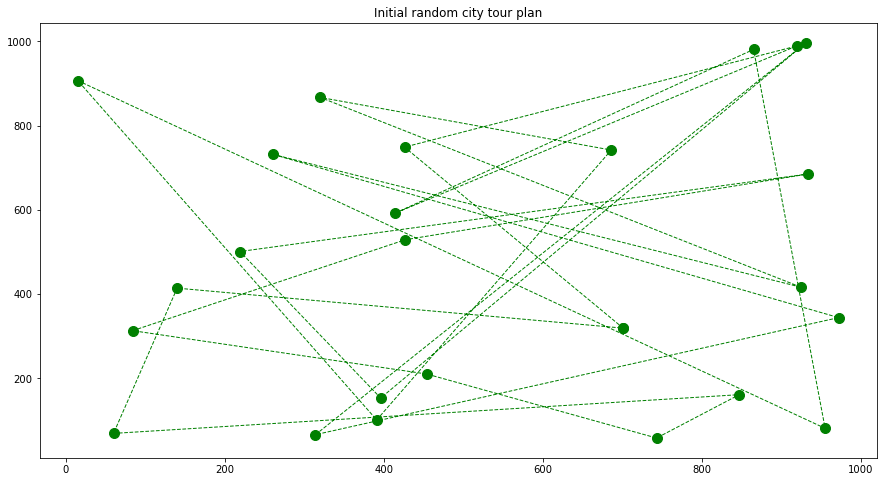

In [17]:
x_coord, y_coord = get_coordinates(tourmanager.getCities())
draw_route(x_coord, y_coord, 'Initial random city tour plan')

In [18]:
pop = Population(tourmanager, population_size, True);
print ('Initial distance:', str(pop.getFittest().getDistance()))

initial_fittest = pop.getFittest()

Initial distance: 11481.040099650767


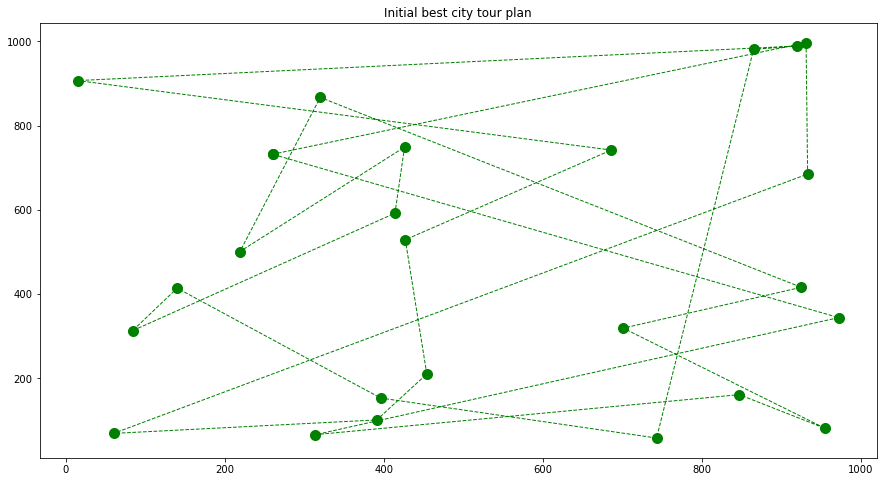

In [19]:
x_coord, y_coord = get_coordinates(initial_fittest)
draw_route(x_coord, y_coord, 'Initial best city tour plan')

In [20]:
ga = GA(tourmanager)
pop = ga.evolvePopulation(pop)

print ('Generating:', number_of_generations, 'generations...')
for i in range(0, number_of_generations):
    pop = ga.evolvePopulation(pop)

fittest = pop.getFittest()
print ("Final distance:", str(fittest.getDistance()))

Generating: 300 generations...
Final distance: 4573.45619812167


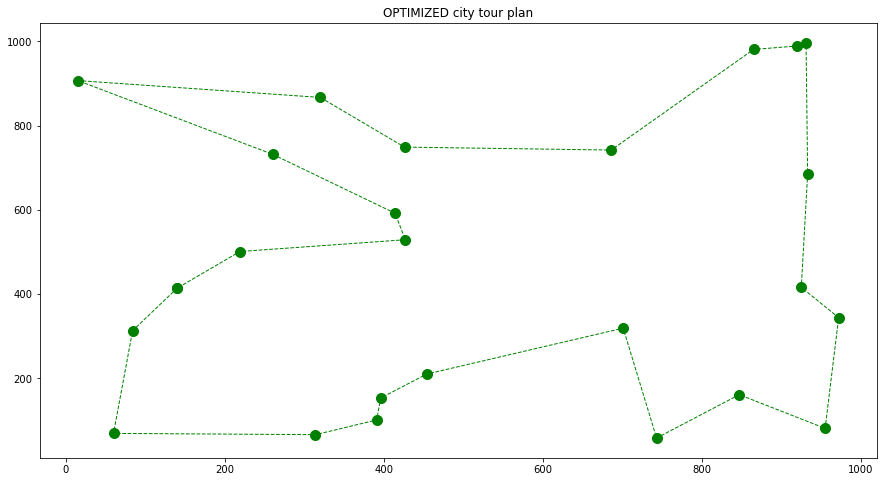

In [21]:
fittest = pop.getFittest()

x_coord, y_coord = get_coordinates(fittest)
draw_route(x_coord, y_coord, 'OPTIMIZED city tour plan')